In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import db_manager as dm
import config_params as cp
import networkx as nx
import pandas as pd
import numpy as np
import math

from datetime import datetime
import matplotlib.pyplot as plt



plt.rcParams['figure.figsize'] = [10, 5]

# Undersøg entities i tweets

In [3]:
#load entities ind
entities = dm.query_db("select * from twitter.entity_tweets")

In [4]:
print("shape of entities tbl: ", entities.shape)
entities.head(5)

shape of entities tbl:  (31682, 6)


,tweet_id,mentioned_id,tag,url,annotation_type,annontation_text
0,1477374856245166081,1462520590884126721,None,None,None,None
1,1477374856245166081,None,2022NewYear,None,None,None
2,1477374834829111297,129159317,None,None,None,None
3,1477374834829111297,None,dkpol,None,None,None
4,1477374804021989379,4289258058,None,None,None,None


In [5]:
print("antal mentions i tweets:", entities[~entities['mentioned_id'].isna()].shape[0])
print("antal urls i tweets:", entities[~entities['url'].isna()].shape[0])
print("antal tags i tweets:", entities[~entities['tag'].isna()].shape[0])

antal mentions i tweets: 15017
antal urls i tweets: 5980
antal tags i tweets: 10381


## 10 mest anvendte tags i dkpol (på nær #dkpol)

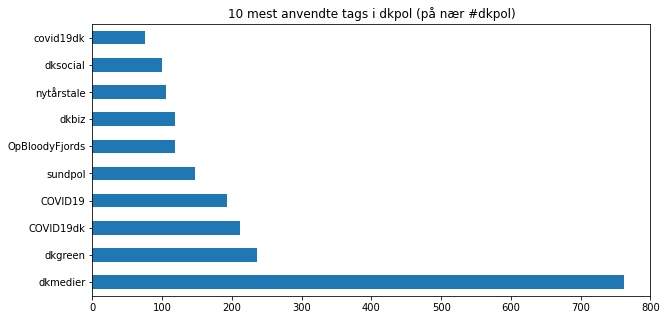

In [6]:
title = "10 mest anvendte tags i dkpol (på nær #dkpol)"

k = 11
top_k_tags = list(entities.tag.value_counts().head(k).index)
top_k_tags.remove("dkpol")

entities[entities['tag'].isin(top_k_tags)]['tag'].value_counts().plot.barh(title=title)

In [7]:
def get_domain(url):
    return url.split("/")[2]

In [8]:
entities['url_domain'] = [get_domain(url) if url is not None else None for url in entities.url.values ]

## 10 mest hyppige domæner i dkpol (på nær twitter.com)

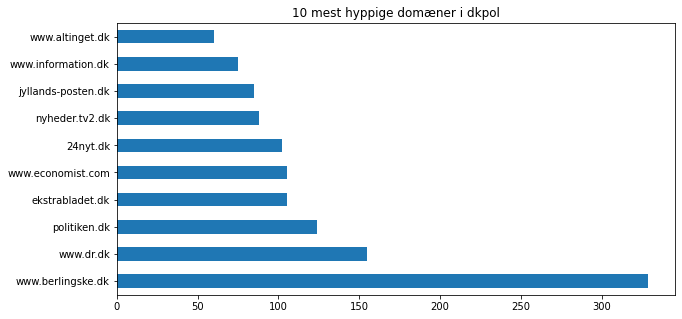

In [9]:
title="10 mest hyppige domæner i dkpol"
k = 11

top_k_tags = list(entities.url_domain.value_counts().head(k).index)
top_k_tags.remove("twitter.com")

entities[entities['url_domain'].isin(top_k_tags)]['url_domain'].value_counts().plot.barh(title=title)

# Undersøg tweets

In [10]:
tweets = dm.query_db("select * from twitter.tweets")

In [11]:
print("shape of tweets tbl: ", tweets.shape)
tweets.head(3)

shape of tweets tbl:  (19194, 11)


,author_id,tweet_id,conversation_id,referenced_type,referenced_id,created_at,text,retweet_count,reply_count,like_count,quote_count
0,27206715,1477374856245166081,1477374856245166081,retweeted,1476937026859683846,2022-01-01 20:23:08,RT @MahmoudSuhil: Jeg ønsker alle et godt nytå...,12,0,0,0
1,92745620,1477374834829111297,1477374834829111297,None,None,2022-01-01 20:23:03,Så @btdk’s dækning af statsministerens nytårst...,0,0,0,0
2,564124584,1477374804021989379,1477374804021989379,None,None,2022-01-01 20:22:56,"Hvis @regeringDK ønsker danske arbejdspladser,...",0,0,0,0


In [12]:
print("antal tweets, der ikke er referencer:", tweets[tweets['referenced_type'].isna()].shape[0])

antal tweets, der ikke er referencer: 4293


In [13]:
tweets_hour = tweets['created_at'].dt.hour.values
sorted_hour = sorted(tweets_hour)
sorted_h_str = ["kl. " + str(h) for h in sorted_hour]

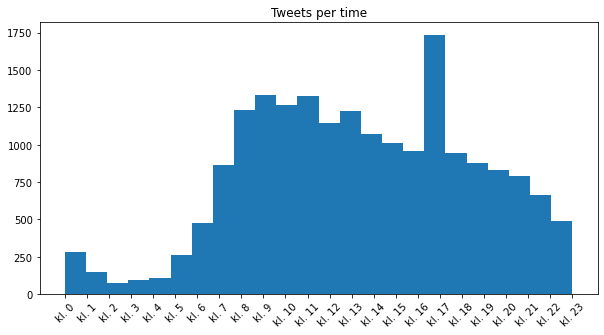

In [14]:
plt.hist(sorted_h_str, bins=24)
plt.xticks(rotation='45')
plt.title("Tweets per time")
plt.show()

In [15]:
orig_tweets = tweets[tweets['referenced_type'].isna()]

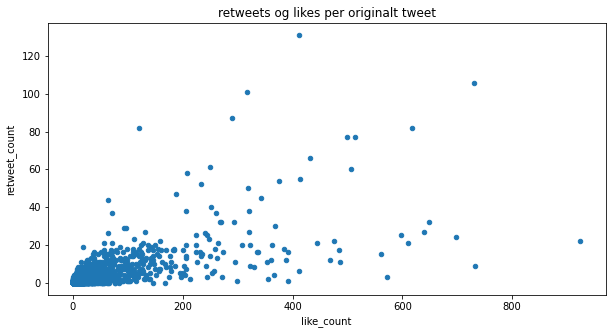

In [16]:
orig_tweets.plot('like_count', 'retweet_count', kind="scatter", title="retweets og likes per originalt tweet")

In [17]:
tweets.author_id.unique()

array(['27206715', '92745620', '564124584', ..., '985076289597042688',
       '1013460111199821826', '14106176'], dtype=object)

# Undersøg users

In [18]:
dk_tw_cnt = tweets.groupby(["author_id"]).agg({"tweet_id": "count"}).reset_index()
dk_tw_cnt.columns = ['id', 'n_dkpol_tweets']

In [19]:
users = dm.query_db("select * from twitter.users")
print(users.shape)

users.head(5)


(4939, 10)


,description,name,id,created_at,username,verified,following_count,followers_count,tweet_count,listed_count
0,Actively interested in politics - liberal. \nF...,Egil Rindorf,276433741,2011-04-03T10:32:39.000Z,EgilRindorf,False,115,75,188,5
1,infantil gadedreng med i Ældresagen Tilhænger ...,CHill,1133007036931874816,2019-05-27T13:48:22.000Z,JacobHo19670490,False,274,49,218,0
2,"Naturgeograf, har arbejdet med satellitkortlæg...",Niels C. Nielsen er optimisisk på trods 🇩🇰 🇬🇧,88294589,2009-11-07T23:08:37.000Z,NiChNi,False,1421,917,29594,70
3,optimist because of will 🙌 // chef for Banking...,Karl Kjær Bang,854553068,2012-09-30T11:26:20.000Z,karlkbang,False,743,570,547,17
4,"Mom, Social Educator, Family Counselor. Here t...",Rana Z.C. #FreePalestine #EndSettlerColonialism,913760800350900224,2017-09-29T13:42:06.000Z,nellachai,False,2186,494,6926,1


In [20]:
users = users.merge(dk_tw_cnt,
                   how="left",
                   on="id")

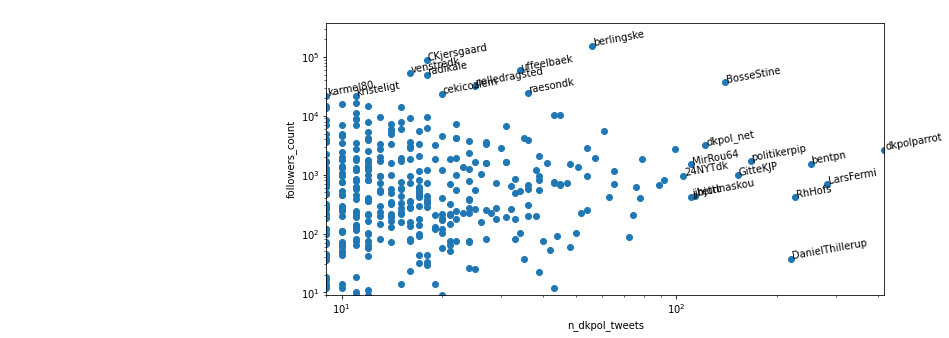

In [37]:
plt.yscale("log")
plt.xscale("log")

plt.xlim([9, users["n_dkpol_tweets"].max()])
plt.ylim([9, users["followers_count"].max()])
plt.scatter(users["n_dkpol_tweets"], users["followers_count"], marker="o")

plt.xlabel('n_dkpol_tweets')
plt.ylabel('followers_count')

for x,y, name in zip(users["n_dkpol_tweets"], users["followers_count"], users['username']):
    if x > 100 or y > 20000:
        plt.annotate(name, (x,y), rotation="10")

# byg en mention-graf

1. directed graf, hvor nodes er brugere, og edges er når én bruger nævner en anden
2. noder har attributter: navn, n_followers, created_date
3. edges har created_date, tweet_id


### forudsætninger

tabel, hvor hver række er én bruger, der nævner en anden bruger


In [23]:
tweets.head(5)

,author_id,tweet_id,conversation_id,referenced_type,referenced_id,created_at,text,retweet_count,reply_count,like_count,quote_count
0,27206715,1477374856245166081,1477374856245166081,retweeted,1476937026859683846,2022-01-01 20:23:08,RT @MahmoudSuhil: Jeg ønsker alle et godt nytå...,12,0,0,0
1,92745620,1477374834829111297,1477374834829111297,None,None,2022-01-01 20:23:03,Så @btdk’s dækning af statsministerens nytårst...,0,0,0,0
2,564124584,1477374804021989379,1477374804021989379,None,None,2022-01-01 20:22:56,"Hvis @regeringDK ønsker danske arbejdspladser,...",0,0,0,0
3,1237424391941693442,1477374377876500480,1477374377876500480,retweeted,1477334697936142339,2022-01-01 20:21:14,"RT @CharlotteLundDi: De der nyttejobs, som sta...",2,0,0,0
4,4871281751,1477374232732524544,1477374232732524544,None,None,2022-01-01 20:20:40,Stort tillykke til Ældre Sagen.\nMan pustede e...,0,0,0,0


In [54]:
users[users['username'] == "PromoteUkraine"]

,description,name,id,created_at,username,verified,following_count,followers_count,tweet_count,listed_count,n_dkpol_tweets
4789,The Future is Europe! Follow us for analysis a...,Promote Ukraine,3995036555,2015-10-19T14:24:44.000Z,PromoteUkraine,False,857,3126,8551,53,1.0


In [24]:
users.head(5)

,description,name,id,created_at,username,verified,following_count,followers_count,tweet_count,listed_count,n_dkpol_tweets
0,Actively interested in politics - liberal. \nF...,Egil Rindorf,276433741,2011-04-03T10:32:39.000Z,EgilRindorf,False,115,75,188,5,1.0
1,infantil gadedreng med i Ældresagen Tilhænger ...,CHill,1133007036931874816,2019-05-27T13:48:22.000Z,JacobHo19670490,False,274,49,218,0,7.0
2,"Naturgeograf, har arbejdet med satellitkortlæg...",Niels C. Nielsen er optimisisk på trods 🇩🇰 🇬🇧,88294589,2009-11-07T23:08:37.000Z,NiChNi,False,1421,917,29594,70,2.0
3,optimist because of will 🙌 // chef for Banking...,Karl Kjær Bang,854553068,2012-09-30T11:26:20.000Z,karlkbang,False,743,570,547,17,1.0
4,"Mom, Social Educator, Family Counselor. Here t...",Rana Z.C. #FreePalestine #EndSettlerColonialism,913760800350900224,2017-09-29T13:42:06.000Z,nellachai,False,2186,494,6926,1,1.0


In [25]:

#tag alle rækker, hvor der er mentions
mentions = entities[~entities['mentioned_id'].isna()][["tweet_id","mentioned_id"]]
print("mentions:", mentions.shape)

# join author_id på
mentions_and_authors = mentions.merge(tweets[["author_id", "tweet_id", "created_at"]],
                                      how="inner",
                                      on="tweet_id")


print("mentions and authos:", mentions_and_authors.shape)

#join author_user stats på
author_users = users[['username', "followers_count", "id"]]
author_users.columns = ['author_username', "author_followers", "author_id"]




mentions_authors_and_followers_tmp = mentions_and_authors.merge(author_users,
                                                           how="inner",
                                                           on="author_id",
        
                                                               )

print("mentions and authors and followers step 1:", mentions_authors_and_followers_tmp.shape)


#join mentioned_user stats på
mentioned_users = users[['username', "followers_count", "id"]]
mentioned_users.columns = ['mentioned_username', "mentioned_followers", "mentioned_id"]


maf = mentions_authors_and_followers_tmp.merge(mentioned_users,
                                                           how="inner",
                                                           on="mentioned_id",
                                                           )


print("mentions and authors and followers step 2:", maf.shape)


mentions: (15017, 2)
mentions and authos: (15017, 4)
mentions and authors and followers step 1: (15016, 6)
mentions and authors and followers step 2: (12632, 8)


In [38]:
follower_threshold = 3000

power_maf = maf[(maf['author_followers'] > follower_threshold) 
                & (maf['mentioned_followers'] > follower_threshold)]
power_maf.shape

(1022, 8)

In [39]:
G = nx.MultiDiGraph()

for i, row in power_maf.iterrows():
    G.add_edge(row.author_username, 
               row.mentioned_username,
               created_at = row.created_at.strftime("%Y-%m-%dT%H:%M:%SZ"),
               #created_at = row.created_at.isoformat(),
               tweet_id = row.tweet_id
              )
    
    #G.nodes[row.author_id]['username'] = row.author_username
    G.nodes[row.author_username]['followers'] = row.author_followers
    
    
    #G.nodes[row.mentioned_id]['username'] = row.mentioned_username
    G.nodes[row.mentioned_username]['followers'] = row.mentioned_followers
    
    
    


In [40]:
def get_max_date(d):
    dates = [v['created_at'] for v in d.values()]
 
    return max(dates)

def get_min_date(d):
    dates = [v['created_at'] for v in d.values()]
    return min(dates)

In [47]:
#convert to digraph

G2 = nx.DiGraph()


for n1,n2,data in G.in_edges(data=True):
    
    if len(G[n1][n2]) == 1:
        G2.add_edge(n1,n2,
                   start = data['created_at'],
                   end = data['created_at'])

    if len(G[n1][n2]) > 1:
        G2.add_edge(n1,n2,
               start = get_min_date(dict(G[n1][n2])),
               end = get_max_date(dict(G[n1][n2]))
                   )
        

        
        
for node, data in G.nodes(data=True):
    G2.add_node(node, followers = data['followers'])
    
    start_dates = [data['start'] for n1,n2, data in G2.in_edges(node, data=True)]
    
    start_dates += [data['start'] for n1,n2, data in G2.out_edges(node, data=True)]
    
    
    end_dates = [data['end'] for n1,n2, data in G2.in_edges(node, data=True)]
    
    end_dates += [data['end'] for n1,n2, data in G2.out_edges(node, data=True)]
    
    
    G2.nodes[node]['start'] = min(start_dates)
    G2.nodes[node]['end'] = max(end_dates)
    
    

In [48]:
for n1,n2,data in G2.edges(data=True):
    print(data)
    break

{'start': '2022-01-01T18:19:59Z', 'end': '2022-01-01T18:19:59Z'}


In [49]:
nx.write_gexf(G2, "mention_G.gexf")